# Darmstadt Urban Heat Typology Analysis
- Geoff & Avi - 10-26-24
- we're trying to understand the affect of different types of 'built environment' on urban heat patterns
- starting with data collected from Darmstadt

In [27]:
#import data libraries
import pandas as pd

#import geographic analysis libraries
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely as shp
from shapely.geometry import Point
from shapely.geometry import shape
import seaborn as sns
import os
import re
from fiona.crs import from_epsg
import pysal as ps
#set crs for entire analysis
crs = {'init': 'epsg:4326'}
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100

In [28]:
#import machine learning / regression libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [61]:
### read in data
temp_df = pd.read_excel('../data/UHT_paper_data.xlsx', sheet_name='Temp')
area_df = pd.read_excel('../data/darmstadt_area_table.xlsx')
temp_disagg_df = pd.read_excel('../data/HW_data_v2.xlsx', sheet_name='DT_mean')

In [62]:
area_df.head()

,Name_Bezir,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,Distist_area
0,110 Stadtzentrum,123300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27900.0,NaN,25200.0,115200.0,301500.0
1,120 Rheintor/Grafenstraße,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233100.0,399600.0
2,130 Hochschulviertel,115200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36000.0,NaN,NaN,NaN,416700.0
3,140 Kapellplatzviertel,18000.0,NaN,NaN,11700.0,35100.0,11700.0,45900.0,NaN,177300.0,NaN,NaN,NaN,491400.0
4,150 St. Ludwig mit Eichbergviertel,NaN,NaN,NaN,33300.0,22500.0,18000.0,189000.0,NaN,188100.0,21600.0,NaN,NaN,720900.0


In [63]:
area_df.fillna(0, inplace=True)

In [64]:
area_df.shape

(34, 14)

In [68]:
area_df.head()

,Name_Bezir,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,Distist_area
0,110 Stadtzentrum,123300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27900.0,0.0,25200.0,115200.0,301500.0
1,120 Rheintor/Grafenstraße,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233100.0,399600.0
2,130 Hochschulviertel,115200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36000.0,0.0,0.0,0.0,416700.0
3,140 Kapellplatzviertel,18000.0,0.0,0.0,11700.0,35100.0,11700.0,45900.0,0.0,177300.0,0.0,0.0,0.0,491400.0
4,150 St. Ludwig mit Eichbergviertel,0.0,0.0,0.0,33300.0,22500.0,18000.0,189000.0,0.0,188100.0,21600.0,0.0,0.0,720900.0


In [67]:
typology_list = ['EST11', 'EST12', 'EST13', 'EST1A', 'EST1B', 'EST2',
       'EST3', 'EST4', 'EST5', 'EST6', 'EST7', 'EST8']

In [69]:
for typology in typology_list:
    new_column_name = typology+'_pct'
    area_df[new_column_name] = area_df[typology] / area_df['Distist_area']

In [72]:
area_df_small = area_df[['Name_Bezir', 'EST11_pct', 'EST12_pct', 'EST13_pct', 'EST1A_pct', 'EST1B_pct',
       'EST2_pct', 'EST3_pct', 'EST4_pct', 'EST5_pct', 'EST6_pct', 'EST7_pct',
       'EST8_pct']]

In [73]:
area_df_small.rename(columns={'Name_Bezir': 'district'}, inplace=True)

/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_67502/3729337601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_df_small.rename(columns={'Name_Bezir': 'district'}, inplace=True)


In [35]:
darmstadt_shp = gpd.read_file('../data/restatisticalanalysissos/20240506_Darmstadt_District_Typology_divided_shapefile.shp')

In [90]:
darmstadt_shp.head()

,Layer_left,Name_Bezir,Entity_lef,Handle,LyrFrzn,LyrOn,Color_left,Linetype_l,Elevation_,LineWt_lef,RefName_le,DocUpdate,DocId,GlobalWidt,Shape_Leng,Shape_Area,index_righ,OBJECTID,Entity_rig,Layer_righ,Color_righ,Linetype_r,Elevatio_1,LineWt_rig,RefName_ri,Shape_Le_1,Shape_Ar_1,Final_laye,geometry
0,EST11_park,110 Stadtzentrum,2DPolyline2DPolyline,6A7C7871,0,2,144,ContinuousContinuous,0.0,140,0.0,2024-04-252024-04-25,1.456447e+19,0.0,2015.933934,121041.413541,32,34,LWPolylineLWPolyline,10011001,14,ContinuousContinuous,0.0,50,0.0,5191.575715,5.997102e+05,110 Stadtzentrum_EST11_park,"MULTIPOLYGON Z (((8.64996 49.87541 0.00000, 8...."
1,EST11_park,130 Hochschulviertel,2DPolyline,7871,0,1,72,Continuous,0.0,70,0.0,2024-04-25,7.282236e+18,0.0,1619.688981,113675.528110,17,18,LWPolyline,1001,7,Continuous,0.0,25,0.0,2811.905234,4.144146e+05,130 Hochschulviertel_EST11_park,"POLYGON Z ((8.65074 49.88018 0.00000, 8.65276 ..."
2,EST11_park,140 Kapellplatzviertel,2DPolyline,78DB,0,1,72,Continuous,0.0,70,0.0,2024-04-25,7.282236e+18,0.0,630.405464,17939.223471,20,21,LWPolyline,1001,7,Continuous,0.0,25,0.0,3382.614724,4.963466e+05,140 Kapellplatzviertel_EST11_park,"POLYGON Z ((8.65481 49.86413 0.00000, 8.65544 ..."
3,EST11_park,270 Am Ziegelbusch,2DPolyline,534B,0,1,72,Continuous,0.0,70,0.0,2024-04-25,7.282236e+18,0.0,1243.827946,19996.898504,9,10,LWPolyline,1001,7,Continuous,0.0,25,0.0,6249.417123,2.431327e+06,270 Am Ziegelbusch_EST11_park,"POLYGON Z ((8.66620 49.88473 0.00000, 8.66660 ..."
4,EST11_park,310 Am Oberfeld,2DPolyline,5DA3,0,1,72,Continuous,0.0,70,0.0,2024-04-25,7.282236e+18,0.0,237.168703,2566.217829,6,7,LWPolyline,1001,7,Continuous,0.0,25,0.0,20788.406205,1.920096e+07,310 Am Oberfeld_EST11_park,"POLYGON Z ((8.67007 49.87927 0.00000, 8.66998 ..."


In [37]:
darmstadt_shp_small = darmstadt_shp[['Final_laye', 'Layer_left', 'geometry']]

In [46]:
temp_disagg_df_small = temp_disagg_df[['Final_laye', 'AREA', 'HW_avg', 'not_HW_avg']]
temp_disagg_df_small.columns = ['distrct_typology', 'area', 'hw_avg', 'not_hw_avg']

In [78]:
lst_df = pd.read_excel('../data/darmstadt_LST.xlsx')

In [80]:
lst_df_small = lst_df[['Name_Bezir', 'HW_avg']]

In [82]:
lst_df_small.columns = ['district', 'HW_avg']

In [84]:
lst_df_small.shape

(34, 2)

In [85]:
area_df_small.shape

(34, 13)

In [86]:
area_w_temp = area_df_small.merge(lst_df_small)

In [87]:
area_w_temp.head()

,district,EST11_pct,EST12_pct,EST13_pct,EST1A_pct,EST1B_pct,EST2_pct,EST3_pct,EST4_pct,EST5_pct,EST6_pct,EST7_pct,EST8_pct,HW_avg
0,110 Stadtzentrum,0.408955,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.092537,0.000000,0.083582,0.382090,39.436830
1,120 Rheintor/Grafenstraße,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.583333,39.200845
2,130 Hochschulviertel,0.276458,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.086393,0.000000,0.000000,0.000000,37.654671
3,140 Kapellplatzviertel,0.036630,0.0,0.0,0.023810,0.071429,0.023810,0.093407,0.0,0.360806,0.000000,0.000000,0.000000,37.708665
4,150 St. Ludwig mit Eichbergviertel,0.000000,0.0,0.0,0.046192,0.031211,0.024969,0.262172,0.0,0.260924,0.029963,0.000000,0.000000,37.354722


In [88]:
area_w_temp.columns

Index(['district', 'EST11_pct', 'EST12_pct', 'EST13_pct', 'EST1A_pct',
       'EST1B_pct', 'EST2_pct', 'EST3_pct', 'EST4_pct', 'EST5_pct', 'EST6_pct',
       'EST7_pct', 'EST8_pct', 'HW_avg'],
      dtype='object')

In [89]:
### put together X and y for regression
y = area_w_temp.HW_avg
### get list of all new dummy columns and all other columns of interest
X_columns = [ 'EST11_pct', 'EST12_pct', 'EST13_pct', 'EST1A_pct',
       'EST1B_pct', 'EST2_pct', 'EST3_pct', 'EST4_pct', 'EST5_pct', 'EST6_pct',
       'EST7_pct', 'EST8_pct']
X = area_w_temp[X_columns]

### fit linear regression to X and y (not x train and y train)
model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 HW_avg   R-squared (uncentered):                   0.755
Model:                            OLS   Adj. R-squared (uncentered):              0.622
Method:                 Least Squares   F-statistic:                              5.656
Date:                Sat, 26 Oct 2024   Prob (F-statistic):                    0.000233
Time:                        11:19:27   Log-Likelihood:                         -146.28
No. Observations:                  34   AIC:                                      316.6
Df Residuals:                      22   BIC:                                      334.9
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
EST11_pct     80.0690     73.572      1.088      0.288     -72.510     232.648
EST12_pct    758.2396   1197.497      0.633      0.533   -1725.218    3241.697
EST13_pct    205.9529    196.248      1.049      0.305    -201.040     612.946
EST1A_pct     83.9535     57.225      1.467      0.157     -34.725     202.632
EST1B_pct     97.2214    291.862      0.333      0.742    -508.063     702.506
EST2_pct      29.0899    145.638      0.200      0.844    -272.945     331.124
EST3_pct     104.8489     48.619      2.157      0.042       4.019     205.679
EST4_pct     181.8364    188.623      0.964      0.346    -209.343     573.016
EST5_pct      50.3617     18.144      2.776      0.011      12.733      87.991
EST6_pct      93.0171     72.274      1.287      0.211     -56.870     242.904
EST7_pct    -282.8969    478.898     -0.591      0.561   -1276.070     710.277
EST8_pct      67.2014     38.098      1.764      0.092     -11.810     146.213
==============================================================================
Omnibus:                        3.044   Durbin-Watson:                   1.168
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                1.443
Skew:                          -0.056   Prob(JB):                        0.486
Kurtosis:                       1.997   Cond. No.                         72.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
temp_small = temp_disagg_df[['Name_Bezir', 'Typology', 'HW_avg']]

In [96]:
temp_small_w_dummies = pd.get_dummies(temp_small, columns=['Typology'])

In [98]:
temp_small_w_dummies.columns

Index(['Name_Bezir', 'HW_avg', 'Typology_EST11', 'Typology_EST12',
       'Typology_EST13', 'Typology_EST14', 'Typology_EST1A', 'Typology_EST1B',
       'Typology_EST2', 'Typology_EST3', 'Typology_EST4', 'Typology_EST5',
       'Typology_EST6', 'Typology_EST7', 'Typology_EST8'],
      dtype='object')

In [100]:
temp_small_w_dummies.shape

(192, 15)

In [101]:
temp_small_w_dummies.head()

,Name_Bezir,HW_avg,Typology_EST11,Typology_EST12,Typology_EST13,Typology_EST14,Typology_EST1A,Typology_EST1B,Typology_EST2,Typology_EST3,Typology_EST4,Typology_EST5,Typology_EST6,Typology_EST7,Typology_EST8
0,110 Stadtzentrum,35.961281,1,0,0,0,0,0,0,0,0,0,0,0,0
1,130 Hochschulviertel,35.774225,1,0,0,0,0,0,0,0,0,0,0,0,0
2,140 Kapellplatzviertel,35.394494,1,0,0,0,0,0,0,0,0,0,0,0,0
3,270 Am Ziegelbusch,35.325504,1,0,0,0,0,0,0,0,0,0,0,0,0
4,310 Am Oberfeld,35.544379,1,0,0,0,0,0,0,0,0,0,0,0,0


In [99]:
### put together X and y for regression
y = temp_small_w_dummies.HW_avg
### get list of all new dummy columns and all other columns of interest
X_columns = ['Typology_EST11', 'Typology_EST12',
       'Typology_EST13', 'Typology_EST14', 'Typology_EST1A', 'Typology_EST1B',
       'Typology_EST2', 'Typology_EST3', 'Typology_EST4', 'Typology_EST5',
       'Typology_EST6', 'Typology_EST7', 'Typology_EST8']
X = temp_small_w_dummies[X_columns]

### fit linear regression to X and y (not x train and y train)
model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 HW_avg   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     6.544
Date:                Sat, 26 Oct 2024   Prob (F-statistic):           1.23e-09
Time:                        11:36:39   Log-Likelihood:                -285.74
No. Observations:                 192   AIC:                             597.5
Df Residuals:                     179   BIC:                             639.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Typology_EST11    35.5639      0.420     84.770      0.000      34.736      36.392
Typology_EST12    34.8204      0.785     44.364      0.000      33.272      36.369
Typology_EST13    35.4892      0.335    106.042      0.000      34.829      36.150
Typology_EST14    36.8747      0.227    162.749      0.000      36.428      37.322
Typology_EST1A    36.2938      0.218    166.726      0.000      35.864      36.723
Typology_EST1B    36.9028      0.262    141.052      0.000      36.387      37.419
Typology_EST2     36.6112      0.214    171.388      0.000      36.190      37.033
Typology_EST3     36.7037      0.210    174.974      0.000      36.290      37.118
Typology_EST4     36.3117      0.287    126.700      0.000      35.746      36.877
Typology_EST5     37.6839      0.297    127.029      0.000      37.099      38.269
Typology_EST6     37.5293      0.287    130.949      0.000      36.964      38.095
Typology_EST7     39.6743      0.785     50.549      0.000      38.126      41.223
Typology_EST8     38.9183      0.641     60.729      0.000      37.654      40.183
==============================================================================
Omnibus:                        4.543   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.374
Skew:                          -0.369   Prob(JB):                        0.112
Kurtosis:                       3.036   Cond. No.                         3.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [157]:
### Read in tiff temp file
import xarray as xr

dataarray = xr.open_dataset('../data/Landsurface_Temperature/D_LST_20230905.tif', engine='rasterio')

In [158]:
df = dataarray.to_dataframe()

In [159]:
df.reset_index(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


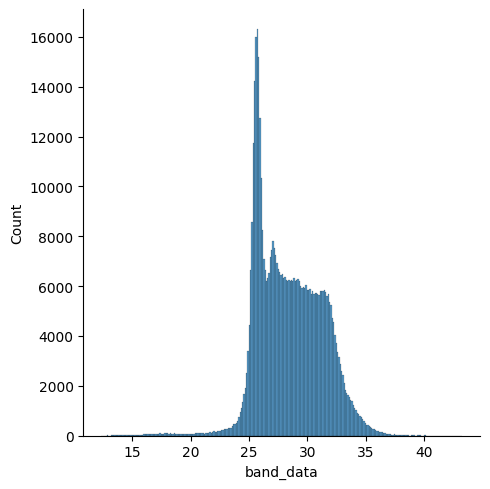

In [160]:
sns.displot(df['band_data'])

In [161]:
geometry = [Point(xy) for xy in zip(df.x, df.y)]
# df = df.drop(['x', 'y'], axis=1)
gdf = GeoDataFrame(df, crs="EPSG:32632", geometry=geometry)

In [162]:
gdf.to_crs(crs='epsg:4326', inplace=True)

In [163]:
gdf.head()

,band,x,y,spatial_ref,band_data,geometry
0,1,462870.0,5533860.0,0,26.066679,POINT (8.48238 49.95594)
1,1,462870.0,5533830.0,0,25.953197,POINT (8.48238 49.95567)
2,1,462870.0,5533800.0,0,25.845158,POINT (8.48239 49.95540)
3,1,462870.0,5533770.0,0,25.720409,POINT (8.48239 49.95513)
4,1,462870.0,5533740.0,0,25.592699,POINT (8.48239 49.95486)


In [164]:
darmstadt_shp = gpd.read_file('../data/Stadtteile/DA_ST_Stadtteile.shp')

In [166]:
darmstadt_shp.to_crs(crs='epsg:4326', inplace=True)

In [167]:
gdf_w_darmstadt = gpd.sjoin(gdf, darmstadt_shp, how='inner')

In [170]:
gdf_w_darmstadt.head()

,band,x,y,spatial_ref,band_data,geometry,index_right,ID,Stadtteil,DAStadttei
109770,1,468240.0,5521830.0,0,30.620413,POINT (8.55823 49.84805),0,32472,500,Darmstadt-West
110381,1,468270.0,5521830.0,0,30.786530,POINT (8.55865 49.84805),0,32472,500,Darmstadt-West
110382,1,468270.0,5521800.0,0,30.687140,POINT (8.55865 49.84778),0,32472,500,Darmstadt-West
110383,1,468270.0,5521770.0,0,30.507778,POINT (8.55865 49.84751),0,32472,500,Darmstadt-West
110384,1,468270.0,5521740.0,0,30.472942,POINT (8.55865 49.84724),0,32472,500,Darmstadt-West


In [172]:
gdf_w_darmstadt['geometry'] = gpd.GeoSeries(gdf_w_darmstadt['geometry']).map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

In [173]:
gdf_w_darmstadt_small = gdf_w_darmstadt[['band_data', 'geometry', 'DAStadttei']]

In [174]:
# Imports
import h3
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely
from shapely.ops import unary_union
from shapely.geometry import mapping, Polygon

In [175]:
# Get union of the shape (whole darmstadt)
union_poly = unary_union(darmstadt_shp.geometry)

In [176]:
temp = mapping(union_poly)

In [177]:
hexes = h3.polyfill(temp,res=8)

In [178]:
darm_hex = pd.DataFrame(hexes,columns=["hex_id"])

In [179]:
# Create hexagon geometry and GeoDataFrame
darm_hex['geometry'] = [Polygon(h3.h3_to_geo_boundary(x, geo_json=True)) for x in darm_hex["hex_id"]]
darm_hex = gpd.GeoDataFrame(darm_hex)

In [180]:
darm_hex.shape

(327, 2)

In [181]:
darm_hex.set_crs(crs='epsg:4326', inplace=True)

,hex_id,geometry
0,887a932911fffff,"POLYGON ((49.94354 8.64914, 49.94481 8.65297, ..."
1,887a9364cbfffff,"POLYGON ((49.94491 8.72748, 49.94617 8.73130, ..."
2,887a9366b9fffff,"POLYGON ((49.94278 8.70869, 49.94405 8.71251, ..."
3,887a9366b5fffff,"POLYGON ((49.94658 8.72017, 49.94785 8.72399, ..."
4,8863926c9bfffff,"POLYGON ((49.92682 8.72229, 49.92809 8.72612, ..."
...,...,...
322,887a9328c9fffff,"POLYGON ((49.88712 8.61472, 49.88839 8.61855, ..."
323,887a932f61fffff,"POLYGON ((49.85638 8.60847, 49.85765 8.61231, ..."
324,887a9321a7fffff,"POLYGON ((49.85591 8.58231, 49.85718 8.58615, ..."
325,8863926ca9fffff,"POLYGON ((49.89064 8.71192, 49.89191 8.71575, ..."


In [182]:
gdf_w_darmstadt_small.head()

,band_data,geometry,DAStadttei
109770,30.620413,POINT (49.84805 8.55823),Darmstadt-West
110381,30.786530,POINT (49.84805 8.55865),Darmstadt-West
110382,30.687140,POINT (49.84778 8.55865),Darmstadt-West
110383,30.507778,POINT (49.84751 8.55865),Darmstadt-West
110384,30.472942,POINT (49.84724 8.55865),Darmstadt-West


In [183]:
darm_temp_w_hex = gpd.sjoin(gdf_w_darmstadt_small, darm_hex, how='inner', predicate='within')

In [187]:
darm_temp_w_hex.groupby(['hex_id'], as_index=False)['geometry'].count()

,hex_id,geometry
0,8863926c33fffff,394
1,8863926c81fffff,421
2,8863926c83fffff,414
3,8863926c85fffff,415
4,8863926c87fffff,419
...,...,...
322,887a9366d5fffff,408
323,887a9366d7fffff,420
324,887a9366d9fffff,419
325,887a9366dbfffff,416


In [189]:
darm_hex.shape

(327, 2)

<AxesSubplot: >

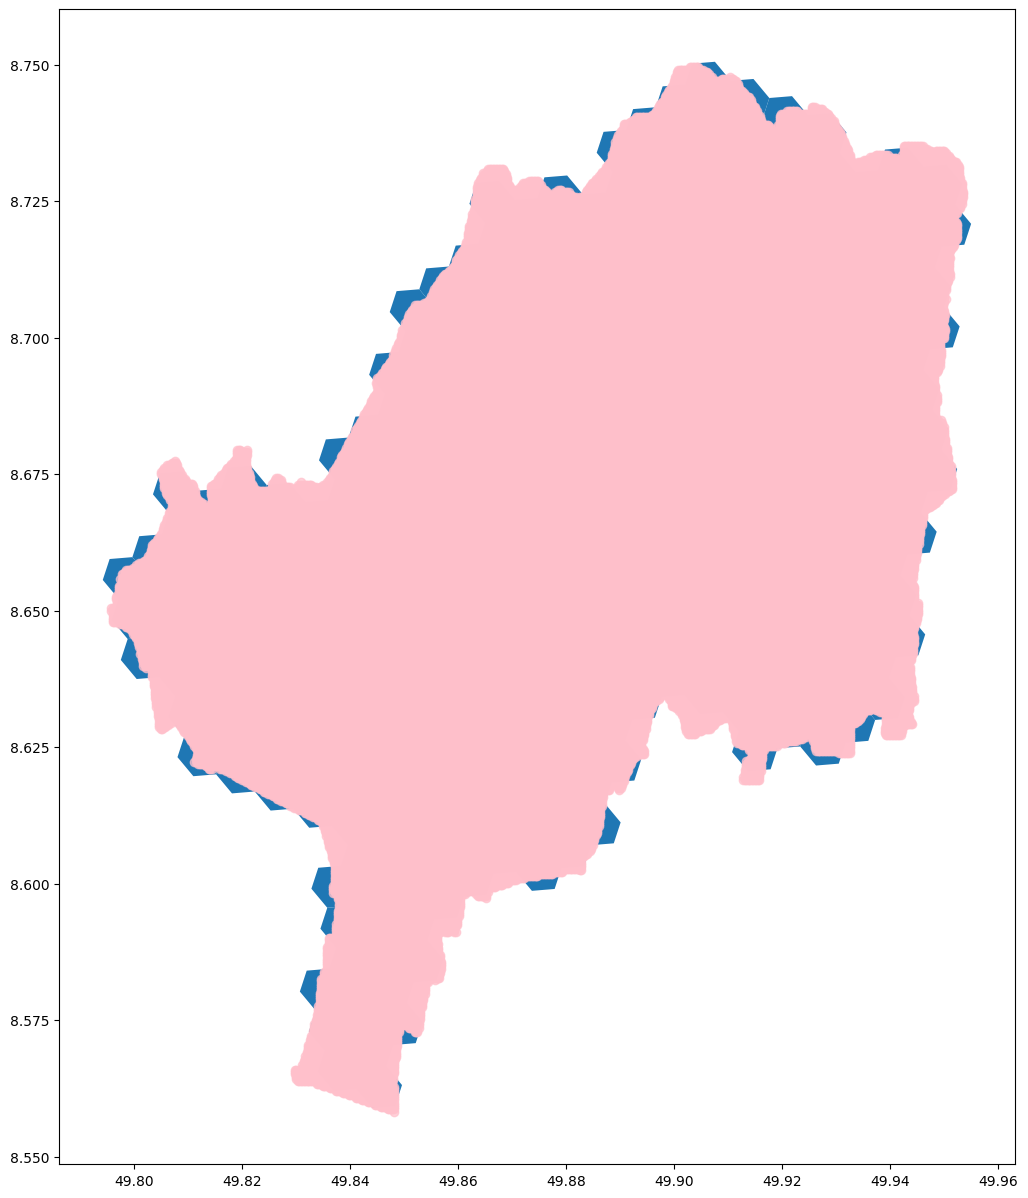

In [186]:
fig, ax = plt.subplots(figsize=(15, 15))
darm_hex.plot(ax=ax)
gdf_w_darmstadt_small.plot(ax=ax, alpha=0.7, color="pink")